### (1) Imports, paths, and config

In [1]:
import sys
import os
from os import environ
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt

from hydra import initialize, compose
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf

# Change twhit to your username (and rest of path as necessary)
os.chdir('/home/twhit/bliss/case_studies/weak_lensing/')
from bliss.catalog import TileCatalog
from lensing_variational_dist import LensingVariationalDistSpec, LensingVariationalDist

In [2]:
environ["BLISS_HOME"] = "/home/twhit/bliss"
with initialize(config_path="../", version_base=None):
    cfg = compose("lensing_config",
                  {"prior.batch_size=4"})

---

### (2) Generate synthetic images

In [3]:
simulator = instantiate(cfg.simulator)
batch = simulator.get_batch()

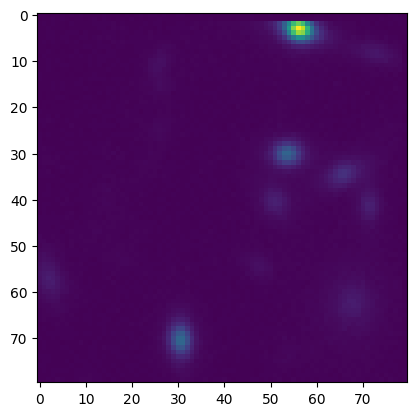

In [4]:
_ = plt.imshow(batch['images'][0][2])

---

### (3) Instantiate encoder

In [5]:
encoder = instantiate(cfg.train.encoder)
target_cat = TileCatalog(encoder.tile_slen, batch["tile_catalog"])
truth_callback = lambda _: target_cat

---

### (4) Train encoder on a single batch of synthetic images

Here we'll just try to learn the shear and convergence for the single batch of synthetic images we generated above. When we actually train via the terminal, we'll do so by pulling in batches from a cached data set. With this single batch, we should be able to infer shear and convergence almost exactly after a sufficient number of iterations.

In [6]:
num_iters = 2000
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)

for i in range(num_iters):
    # Forward pass of encoder
    pred = encoder.infer(batch, truth_callback)
    lvd = pred['marginal']
    
    # Compute loss and take optimizer step
    optimizer.zero_grad()
    loss = lvd.compute_nll(target_cat).mean()
    loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        print('Iteration {}: Loss {}'.format(i, loss.item()))

Iteration 0: Loss 11.630597114562988
Iteration 10: Loss 7.091146469116211
Iteration 20: Loss 5.688786029815674
Iteration 30: Loss 4.659934043884277
Iteration 40: Loss 3.1241958141326904
Iteration 50: Loss 1.9068711996078491
Iteration 60: Loss 1.079552173614502
Iteration 70: Loss 44.36319351196289
Iteration 80: Loss 4.023122787475586
Iteration 90: Loss 3.8739213943481445
Iteration 100: Loss 2.447209119796753
Iteration 110: Loss 1.939577579498291
Iteration 120: Loss 1.7265675067901611
Iteration 130: Loss 1.5885006189346313
Iteration 140: Loss 1.4842100143432617
Iteration 150: Loss 1.3993427753448486
Iteration 160: Loss 1.3207505941390991
Iteration 170: Loss 1.2449935674667358
Iteration 180: Loss 1.1696940660476685
Iteration 190: Loss 1.1004647016525269
Iteration 200: Loss 1.0426630973815918
Iteration 210: Loss 0.9878763556480408
Iteration 220: Loss 0.9358384609222412
Iteration 230: Loss 0.8870247602462769
Iteration 240: Loss 0.8404273986816406
Iteration 250: Loss 0.7936021685600281
Itera

---

### (5) Summarize results

In [7]:
# Optimized variational distribution
q = lvd.factors

#### Horizontal shear

In [8]:
true_shear1_map = batch["tile_catalog"]["shear"].squeeze()[0][:,:,0]
posterior_mean_shear1_map = q["shear"].mean[0][:,:,0].detach()

In [9]:
np.corrcoef(true_shear1_map.flatten(), posterior_mean_shear1_map.flatten())

array([[1.        , 0.90768065],
       [0.90768065, 1.        ]])

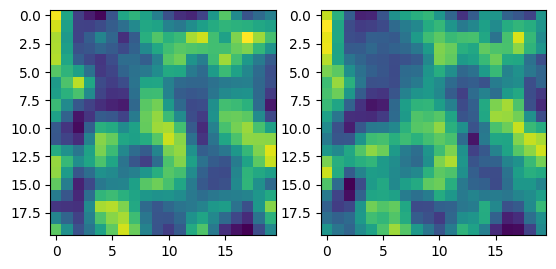

In [10]:
fig, (true, posterior) = plt.subplots(nrows=1, ncols=2)
_ = true.imshow(true_shear1_map)
_ = posterior.imshow(posterior_mean_shear1_map)

#### Diagonal shear

In [11]:
true_shear2_map = batch["tile_catalog"]["shear"].squeeze()[0][:,:,1]
posterior_mean_shear2_map = q["shear"].mean[0][:,:,1].detach()

In [12]:
np.corrcoef(true_shear2_map.flatten(), posterior_mean_shear2_map.flatten())

array([[1.        , 0.93095038],
       [0.93095038, 1.        ]])

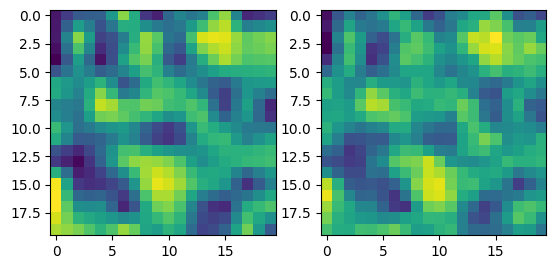

In [13]:
fig, (true, posterior) = plt.subplots(nrows=1, ncols=2)
_ = true.imshow(true_shear2_map)
_ = posterior.imshow(posterior_mean_shear2_map)

#### Convergence

In [14]:
true_convergence_map = batch["tile_catalog"]["convergence"].squeeze()[0]
posterior_mean_convergence_map = q["convergence"].mean[0].detach()

In [15]:
np.corrcoef(true_convergence_map.flatten(), posterior_mean_convergence_map.flatten())

array([[1.        , 0.96826602],
       [0.96826602, 1.        ]])

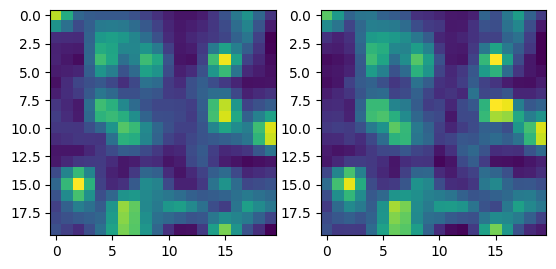

In [16]:
fig, (true, posterior) = plt.subplots(nrows=1, ncols=2)
_ = true.imshow(true_convergence_map)
_ = posterior.imshow(posterior_mean_convergence_map)